# A TUTORIAL ON LINEAR GAUSSIAN STATE SPACE MODELS AND KALMAN FILTERS

by Sebastian T. Glavind, February 2022

In [1]:
import numpy as np
import scipy.stats as ss
from scipy.optimize import minimize 
from skopt import gp_minimize
from scipy.integrate import odeint
import joblib
from matplotlib import pyplot as plt
%matplotlib inline

# Import my kalman filter toolbox
import DLMtools as dlmt

## Properties of the data and the system

In [2]:
# https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf
# Initialization
tstart = 0
tstop = 60
dt = 0.025
# dt = 0.05
# Initial condition
x_init = [0.,0.]
time = np.arange(tstart, tstop, dt)

In [3]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

# System:
# https://stackoverflow.com/questions/47210512/using-pykalman-on-raw-acceleration-data-to-calculate-position
Phi = np.array([ [1, dt, 0.5*dt**2], [0, 1, dt], [0, 0, 1] ])
A = np.array([[ 0, 0, 1 ]])
Qbase_a = Q_continuous_white_noise(dim=3, dt=dt, spectral_density = 1) # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
Qbase_b = Q_discrete_white_noise(dim=3, dt=dt, var = 1) # Labbe (2020), sec. 7.3.2 (variance is a fitting constant)
Qbase_c = np.diag([0., 0., 1.]) # Labbe (2020), sec. 7.3.4 (variance is a fitting constant)

## Example 2: Variable forcing

### Using discrete (deterministic) simulations to solve the ODE system

In [4]:
# https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf
def myDiscSpringSim2(x_init, dt, N, F):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass

    xl = []; xl.append(np.array(x_init).reshape(-1,1)) # Initial Position
    A = np.array( [ [1, dt], [-(dt*k)/m, 1 - (dt*c)/m] ] )  
    B = np.array( [ [0], [dt/m] ] )

    # Simulation
    for s in range(N):
        xl.append( A @ xl[s] + B * F[s] ) # x[s+1]
    xm = np.hstack(xl).T
    
    return(xm)

def myAcc2(x, F):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass
    acc = (F - c*x[:,1] - k*x[:,0])/m
    return(acc)

# Force modeling

# AR
# def myForceSim(N,seed):
#     # AR(2)
#     np.random.seed(seed)
#     w = np.random.normal(size=N)*0.1
#     f = np.zeros(N); f[0] = w[0]
#     for t in range(3,N):
#         f[t] = 0.9*f[t-1] + 0.1*f[t-2] + w[t]
        
#     return(f)

# GP
def se_kern(x, y, sig_f, l_f): # Kernel function: Squared exponential (SE)
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T) # reshape(-1,1): from one-dim. to two-dim. array.
    K = sig_f**2 * np.exp( -0.5 * sqdist / (l_f**2) )
    return(K)

def myForceSim(tvec, sig_f, l_f, seed):
    N = tvec.shape[0]
    # GP
    np.random.seed(seed)
    # Kernel function
    K = se_kern(tvec, tvec, sig_f, l_f)
    # Get cholesky decomposition (square root) of the covariance matrix
    eps=1e-8
    L = np.linalg.cholesky(K + eps*np.eye(N)) # add a litte jitter for numerical stability
    # Sample 3 sets of standard normals for our test points, multiply them by the square root of the covariance matrix
    f = np.dot(L, np.random.normal(size=(N,1)))

    return(f)

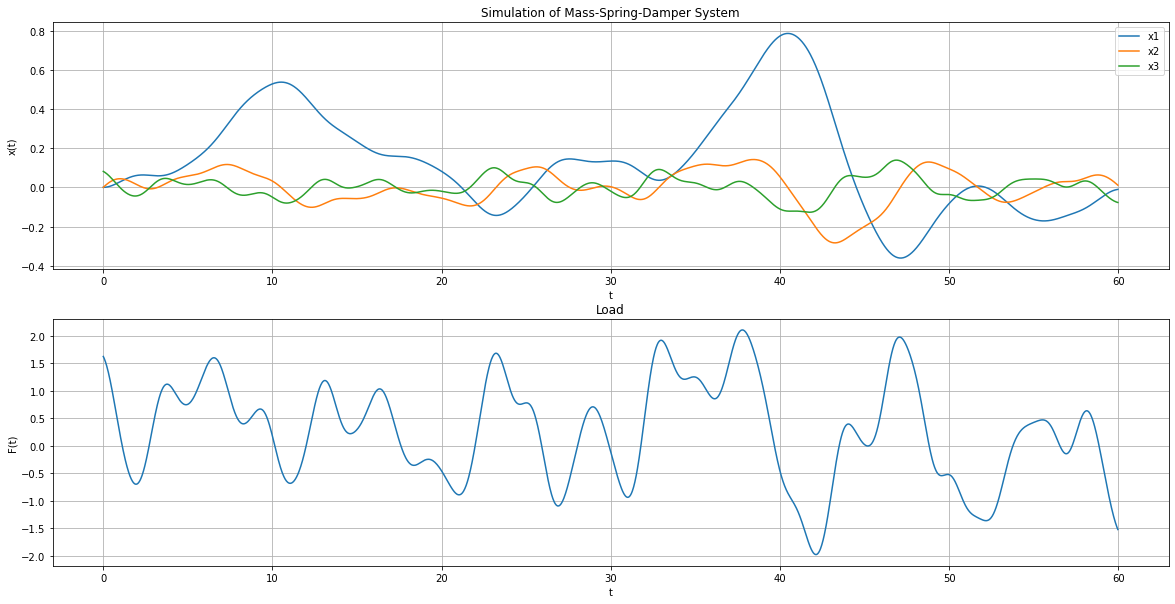

In [5]:
# Solve ODE
N = int((tstop-tstart)//dt) # Simulation length
Ft = myForceSim(tvec=time.reshape(-1,1), sig_f=1, l_f=1, seed=1).flatten()
xsolve2 = myDiscSpringSim2(x_init, dt, N, Ft)
x21 = xsolve2[:,0]
x22 = xsolve2[:,1]
x23 = myAcc2(xsolve2, Ft)

# Plot the Results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

ax1.plot(time,x21)
ax1.plot(time,x22)
ax1.plot(time,x23)
ax1.set_title('Simulation of Mass-Spring-Damper System')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.legend(["x1", "x2", "x3"])
ax1.grid()

ax2.plot(time,Ft)
ax2.set_title('Load')
ax2.set_xlabel('t')
ax2.set_ylabel('F(t)')
ax2.grid()

plt.show()

In [6]:
# # test that veloceties can be reproduced from accelerations
# test=[]; test.append(0.)
# for i in range(len(x23)-1):
#         test.append( test[i] + dt*x23[i] )
#         # Plot the Results
# plt.plot(time,x22)
# plt.plot(time,test, 'r--')
# # plt.plot(time,test-x22); plt.ylim([-1e-8,1e-8])
# plt.title('Simulation of Mass-Spring-Damper System')
# plt.xlabel('t')
# plt.ylabel('x(t)')
# plt.grid()
# plt.show()

### Noisy observations from accelerometers

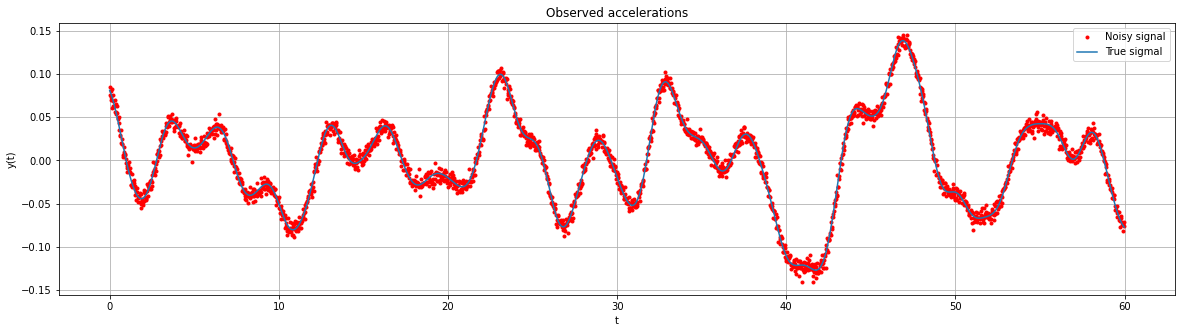

In [7]:
np.random.seed(123)
sig_noise2 = np.std(x23)*0.1
var_noise2 = sig_noise2**2
y2 = x23 + np.random.normal(size=len(x23)) * sig_noise2

# np.savetxt('spring_data_v4.csv', [y2, x21, x22, x23], delimiter=',')

# Plot the Results
plt.figure(figsize=(20,5))
plt.plot(time,y2, 'r.', label='Noisy signal')
plt.plot(time,x23, label='True sigmal')
plt.title('Observed accelerations')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.grid()
plt.show()

### Kalman filtering 

In [8]:
# https://stackoverflow.com/questions/47210512/using-pykalman-on-raw-acceleration-data-to-calculate-position
mu02 = np.linalg.pinv(A) @ np.array([[ y2[0] ]]) # inversion from first measurement (gives the same as above)
Sigma02 = np.eye(3) * np.array([0.25**2 , var_noise2, var_noise2]) # approx. max(pos, vel)^2 (at steady state) and acc. noise variance
# Qtest2 = Qbase_a * (1e-2) # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
# Qtest2 = Qbase_b * (var_noise2) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.2 (variance is a fitting constant)
# Qtest2 = Qbase_c * (var_noise2) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.4 (variance is a fitting constant)
Qtest2 = np.diag([var_noise2*1e-6, var_noise2*1e-4, var_noise2]) # + np.eye(3)*1e-8 # Perris et al (2009), sec. 4.5.1 (DIG)
cQtest2 = np.linalg.cholesky(Qtest2)

In [9]:
xp2, Pp2, xf2, Pf2, xs2, Ps2, negLogLike2 = dlmt.myKalmanSmoother0(y=y2.reshape(-1,1),
                                                                   cQ=cQtest2, cR=np.array([sig_noise2]).reshape(-1,1),  
                                                                   mu0 = mu02, Sigma0 = Sigma02, 
                                                                   A = A, Phi = Phi )

xp2 = np.array(xp2); Pp2 = np.array(Pp2)
xf2 = np.array(xf2); Pf2 = np.array(Pf2)
xs2 = np.array(xs2); Ps2 = np.array(Ps2)
print(negLogLike2)

[[-10753.05301727]]


In [10]:
def plot_kf_estimation(x1,x2,x3,xf,Pf,dt):
    nt = xf.shape[0]
    xax = np.arange(0,nt,1)*dt
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    fig.suptitle('True states vs estimates')
    
    ax1.plot(xax, x1, 'r--', label='True position')
    ax1.plot(xax, xf[:,0,0], 'g--', label='Estimation')
    ax1.fill_between(x=xax, y1=xf[:,0,0]-2*np.sqrt(Pf[:,0,0]), y2=xf[:,0,0]+2*np.sqrt(Pf[:,0,0]), alpha=0.1, color='blue');
    ax1.set_title("Position")
    ax1.legend(loc='upper right')

    ax2.plot(xax, x2, 'r--', label='True position')
    ax2.plot(xax, xf[:,1,0], 'g--', label='Estimation')
    ax2.fill_between(x=xax, y1=xf[:,1,0]-2*np.sqrt(Pf[:,1,1]), y2=xf[:,1,0]+2*np.sqrt(Pf[:,1,1]), alpha=0.1, color='blue');
    ax2.set_title("Velocity")
    ax2.legend(loc='upper right')

    ax3.plot(xax, x3, 'r--', label='True position')
    ax3.plot(xax, xf[:,2,0], 'g--', label='Estimation')
    ax3.fill_between(x=xax, y1=xf[:,2,0]-2*np.sqrt(Pf[:,2,2]), y2=xf[:,2,0]+2*np.sqrt(Pf[:,2,2]), alpha=0.1, color='blue');
    ax3.set_title("Acceleration")
    ax3.legend(loc='upper right')

    plt.show()

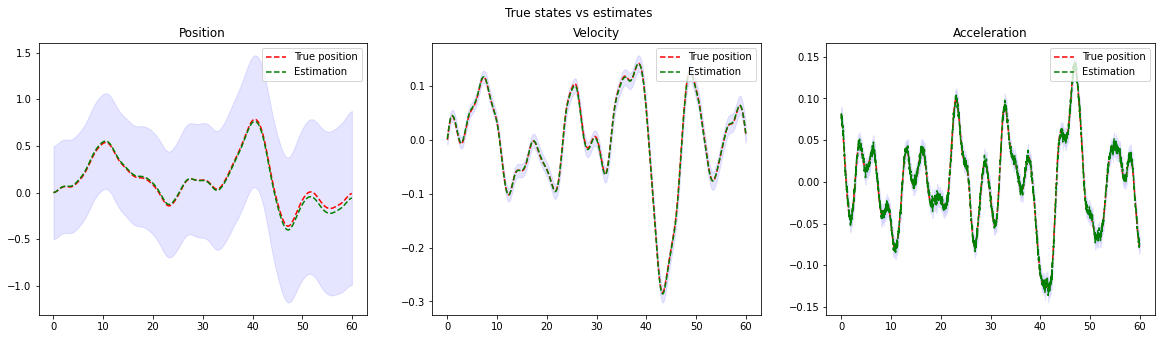

In [11]:
plot_kf_estimation(x21,x22,x23,xf2,Pf2,dt)

### Test filtering against filterpy.kalman.KalmanFilter 

In [12]:
from filterpy.kalman import KalmanFilter

def pos_filterpy(x, P=Sigma02, R=np.array([[var_noise2]]), Q=Qtest2):
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.array([x[0], x[1], x[2]]).reshape(-1,1) # location and velocity
    kf.F = Phi # state transition matrix
    kf.H = A # Measurement function
    kf.R = R # measurement uncertainty
    kf.P[:] = P
    kf.Q[:] = Q
    return kf

def run_pos_filterpy(zs, x0=np.array([0., 0., 0.])):
    # create the Kalman filter
    kf = pos_filterpy(x0)
    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)
    xs, cov = np.array(xs), np.array(cov)
    
    return xs, cov

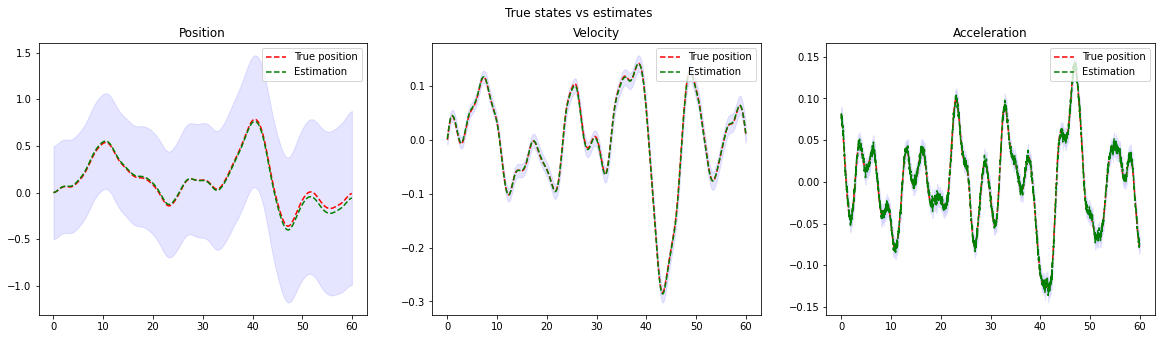

In [13]:
xf_fpy, Pf_fpy = run_pos_filterpy(y2, x0=mu02)

plot_kf_estimation(x21,x22,x23,xf_fpy,Pf_fpy,dt)

### Parameter learning using the Nelder-Mead algorithm 

#### Objective  

In [14]:
# Want to minimize objective
def negLogLikeObj(para):
    if (len(para)==1):
        # Q = Qbase_a * np.exp(para[0]) # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
        # Q = Qbase_b * np.exp(para[0]) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.2 (variance is a fitting constant)
        Q = Qbase_c * np.exp(para[0]) + np.eye(3)*1e-8 # Labbe (2020), sec. 7.3.4 (variance is a fitting constant)
    else:
        Q = np.diag(np.exp(para)) + np.eye(3)*1e-8 # Perris et al (2009), sec. 4.5.1 (DIG)
    cQ = np.linalg.cholesky(Q)
    _, _, _, _, obj = dlmt.myKalmanFiler0(y=y2.reshape(-1,1), 
                                          cQ=cQ, cR=np.array([sig_noise2]).reshape(-1,1), 
                                          mu0 = mu02, Sigma0 = Sigma02, 
                                          A = A, Phi = Phi ) 
    
    return(obj[0,0])

#### Optimization

In [15]:
# para_opt = minimize(fun=negLogLikeObj, x0 = [np.log(var_noise2)], method='Nelder-Mead') # one-parameter version
para_opt = minimize(fun=negLogLikeObj, x0 = [np.log(var_noise2*1e-6), np.log(var_noise2*1e-4), np.log(var_noise2)], method='Nelder-Mead') # three-parameter version
para_opt

 final_simplex: (array([[-23.13057012, -18.81454048, -11.54475569],
       [-23.13062843, -18.81451484, -11.54473979],
       [-23.13053134, -18.81451852, -11.54473477],
       [-23.13061075, -18.81446526, -11.54476127]]), array([-10892.99338202, -10892.99338202, -10892.993382  , -10892.993382  ]))
           fun: -10892.993382017103
       message: 'Optimization terminated successfully.'
          nfev: 96
           nit: 48
        status: 0
       success: True
             x: array([-23.13057012, -18.81454048, -11.54475569])

In [16]:
# # Parallel implementation
# # https://github.com/yngvem/parallelising-python
# np.random.seed(111)
# para_list = [ [np.log(var_noise2), np.log(0.25**2), np.log(var_noise2)]]
# para_list.append( [np.log(var_noise2 * 100), np.log(1**2), np.log(var_noise2*0.1)] )
# for i in range(5):
#     para_list.append( [np.random.uniform(-10., 2.),
#                        np.random.uniform(-15., 1.), 
#                        np.random.uniform(-15., -5.)] )
# def run_loc_opt(para):
#     para_opt = minimize(fun=negLogLikeObj, x0 = para, method='Nelder-Mead')
#     return(para_opt)

# para_opt_list = joblib.Parallel(n_jobs=-2)(joblib.delayed(run_loc_opt)(x) for x in para_list)

# obj_opt_list = []
# for i in range(len(para_opt_list)):
#     obj_opt_list.append( para_opt_list[0].fun )
# para_opt = para_opt_list[np.argmin(obj_opt_list)]

In [17]:
# Qopt = Qbase_c * np.exp(para_opt.x[0]) + np.eye(3)*1e-8 # one-parameter version
Qopt = np.diag(np.exp(para_opt.x)) + np.eye(3)*1e-8 # three-parameter version
cQopt =  np.linalg.cholesky(Qopt)
_, _, xf_opt, Pf_opt, negLogLike_opt = dlmt.myKalmanFiler0(y=y2.reshape(-1,1),
                                                           cQ=cQopt, cR=np.array([sig_noise2]).reshape(-1,1),
                                                           mu0 = mu02, Sigma0 = Sigma02,
                                                           A = A, Phi = Phi )

xf_opt = np.array(xf_opt); Pf_opt = np.array(Pf_opt)
print(negLogLike_opt)

[[-10892.99338202]]


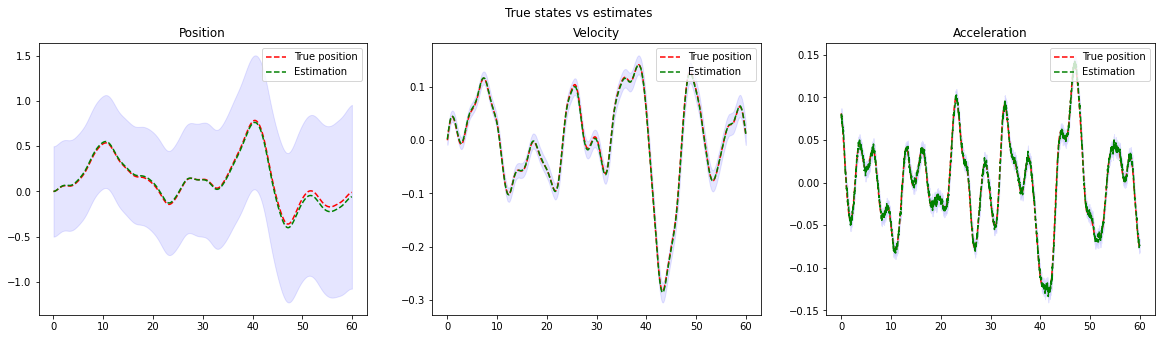

In [18]:
plot_kf_estimation(x21,x22,x23,xf_opt,Pf_opt,dt)

### Parameter learning using Bayesian inference

#### Gibbs sampling using forward filtering backward sampling 

See Shumway & Stoffer (2017; ch. 6) and Petris et al (2009; ch. 4) for a reference on forward filtering, backward sampling for Bayesian inference, and Gelman et al (2013; ch. 11-12) for a general reference on the Markov chain Monte Carlo algorithms.

***
Shumway, R. H. & Stoffer, D. S. (2017). Time series analysis and its applications, Springer.

Gelman, Andrew, et al. Bayesian data analysis. CRC press, 2013.
***

#### Initial model

In [19]:
cQinit =  np.diag([sig_noise2*1e-3, sig_noise2*1e-2, sig_noise2])
# cQinit = np.diag(np.array([0.00090131, 0.00092389, 0.00092494])**0.5)
_, _, xf_init, Pf_init, negLogLike_init = dlmt.myKalmanFiler0(y=y2.reshape(-1,1),
                                                              cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1),
                                                              mu0 = mu02, Sigma0 = Sigma02,
                                                              A = A, Phi = Phi )

xf_init = np.array(xf_init); Pf_init = np.array(Pf_init)
print(negLogLike_init)

[[-10753.05301727]]


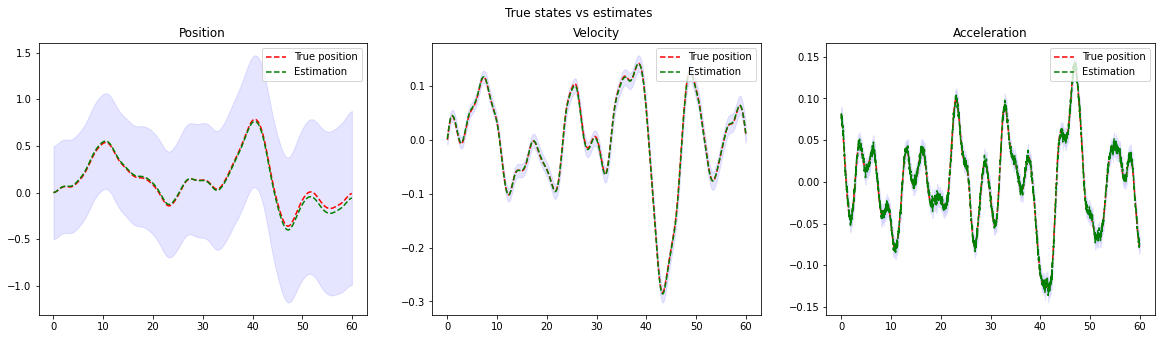

In [20]:
plot_kf_estimation(x21,x22,x23,xf_init,Pf_init,dt)

#### Forward filtering, backward sampling

In [21]:
np.random.seed(1)

collector=[]
for i in range(10):
    xb_test = dlmt.myFFBS(y=y2.reshape(-1,1), cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1),
                          mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi )
    xb_test = np.array(xb_test)
    collector.append(xb_test)

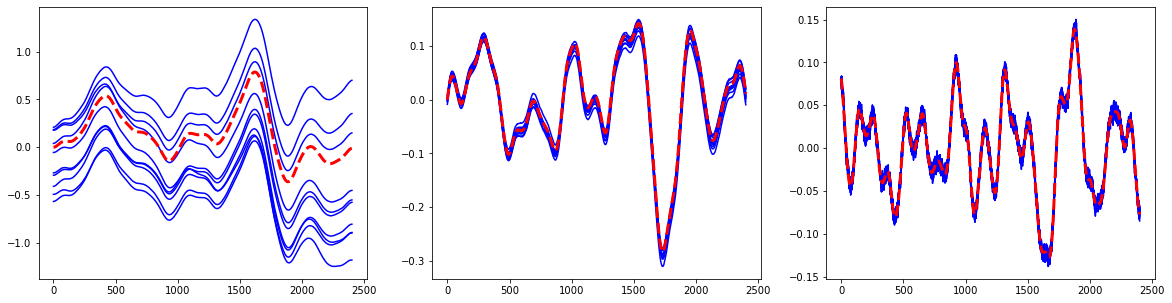

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for col in collector:
    ax1.plot(col[:,0,0], '-b')
    ax2.plot(col[:,1,0], '-b')
    ax3.plot(col[:,2,0], '-b')

ax1.plot(x21,'--r', linewidth=3)
ax2.plot(x22,'--r', linewidth=3)
ax3.plot(x23,'--r', linewidth=3)

plt.show()

#### Posterior sampling under a one-parameter base Q model

In [23]:
np.random.seed(1)
xb_ffbs_base, para_ffbs_base = dlmt.myPosSamplerQbase(y=y2.reshape(-1,1), cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1), 
                                                      mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi,  Qbase = Qbase_b, Nsamp=10)

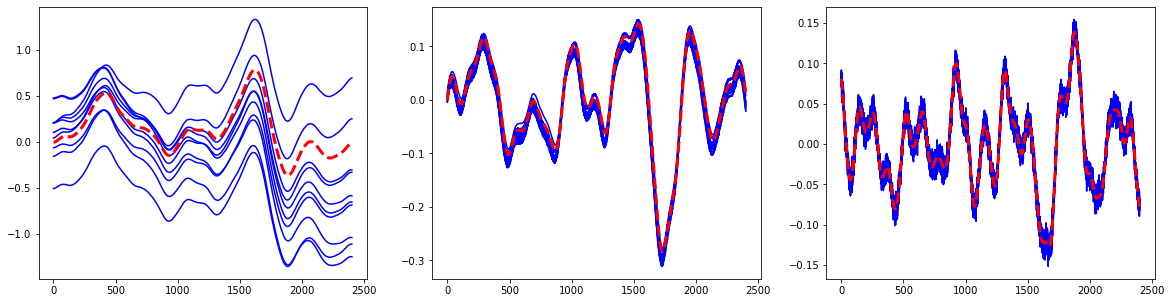

In [24]:
# plot of state space trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for x in xb_ffbs_base:
    ax1.plot(x[:,0,0], '-b')
    ax2.plot(x[:,1,0], '-b')
    ax3.plot(x[:,2,0], '-b')

ax1.plot(x21,'--r', linewidth=3)
ax2.plot(x22,'--r', linewidth=3)
ax3.plot(x23,'--r', linewidth=3)

plt.show()

For this simple covariance-model, it appears that the chain exhibits immediate steady-state behaviour.

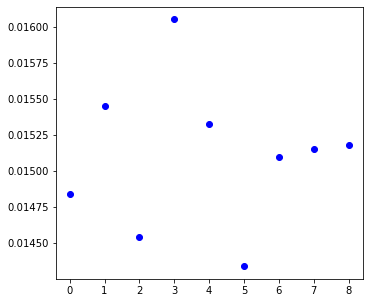

In [25]:
# plot of parameter realizations
plt.figure(figsize=(5.5,5))
plt.plot(np.array(para_ffbs_base)[1:], 'ob')
plt.show()

#### Posterior sampling under the d-inverse Gamma (DIG) model

In [26]:
np.random.seed(1)
xb_ffbs_dig, para_ffbs_dig = dlmt.myPosSamplerDIG(y=y2.reshape(-1,1), cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1), 
                                                  mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi, Nsamp=10)

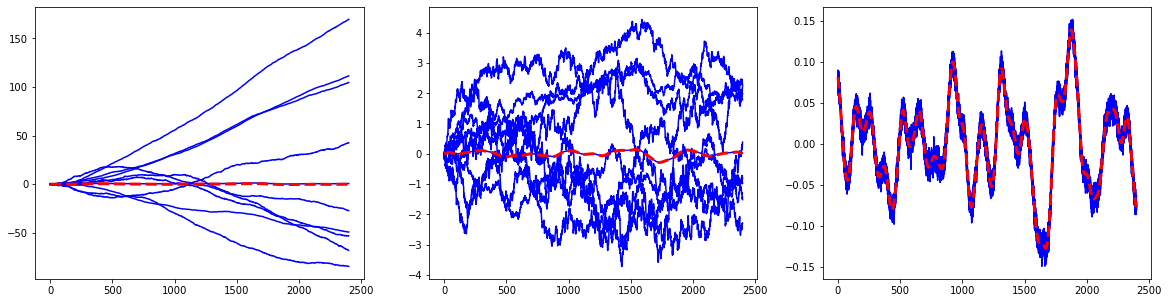

In [27]:
# plot of state space trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for x in xb_ffbs_dig:
    ax1.plot(x[:,0,0], '-b')
    ax2.plot(x[:,1,0], '-b')
    ax3.plot(x[:,2,0], '-b')

ax1.plot(x21,'--r', linewidth=3)
ax2.plot(x22,'--r', linewidth=3)
ax3.plot(x23,'--r', linewidth=3)

plt.show()

As the model becomes more flexible, we see a large set of possible models for velocity and especially displacement that can explain the observations (accelerations). Thus, we observe large uncertainty in the model specification, which is also reflected in the parameter realizations below. Note that for a full/real application, you will have to run the chain until convergence in the parameter realizations.

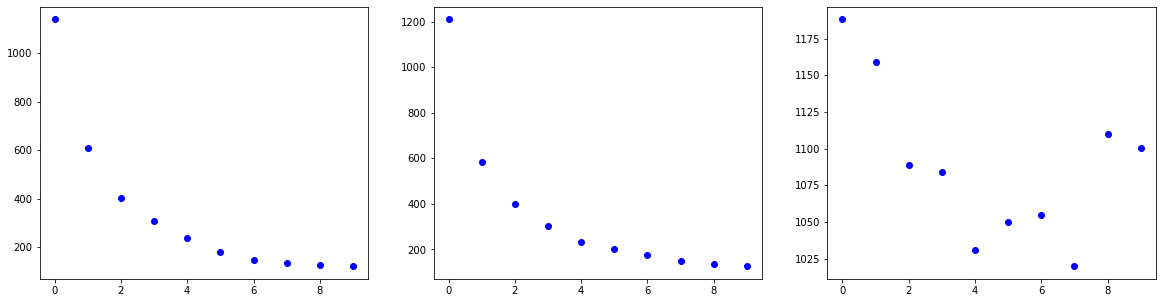

In [28]:
# plot of parameter realizations
para_ffbs_dig_mat = np.array(para_ffbs_dig)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.plot(para_ffbs_dig_mat[:,0], 'ob')
ax2.plot(para_ffbs_dig_mat[:,1], 'ob')
ax3.plot(para_ffbs_dig_mat[:,2], 'ob')
plt.show()